<a href="https://colab.research.google.com/github/Marcos-CT/Proyecto-Tifon/blob/feature%2Feda-marcos/SHAP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title 🔧 Setup Proyecto Tifón (clonado + deps + PYTHONPATH, robusto)
import os, sys, subprocess, shutil, pathlib

REPO_URL    = "https://github.com/Marcos-CT/Proyecto-Tifon.git"
PROJECT_DIR = pathlib.Path("/content/Proyecto-Tifon")
SRC_DIR     = PROJECT_DIR / "src"

def run(cmd, **kw):
    print("➜", " ".join(cmd))
    return subprocess.run(cmd, check=False, **kw)

# 1) Clonar o actualizar de forma segura
if PROJECT_DIR.exists():
    if not (PROJECT_DIR / ".git").exists():
        print("⚠️ Existe /content/Proyecto-Tifon pero no es un repo Git. Lo borro y reclono.")
        shutil.rmtree(PROJECT_DIR, ignore_errors=True)
        run(["git", "clone", REPO_URL, str(PROJECT_DIR)])
    else:
        print("Repo ya existe, actualizando…")
        run(["git", "-C", str(PROJECT_DIR), "fetch", "--all", "--prune"])
        run(["git", "-C", str(PROJECT_DIR), "pull", "--ff-only"])
else:
    print("Clonando repo…")
    run(["git", "clone", REPO_URL, str(PROJECT_DIR)])

# 2) Instalar dependencias con el mismo intérprete
req = PROJECT_DIR / "requirements.txt"
if req.exists():
    print("Instalando dependencias…")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "-r", str(req)])
else:
    print("⚠️ No hay requirements.txt; crea uno para fijar dependencias comunes.")

# 3) Añadir src al PYTHONPATH
if SRC_DIR.exists():
    sys.path.append(str(SRC_DIR))
    print("PYTHONPATH ✔", SRC_DIR)
else:
    print("⚠️ No existe src/. Crea src/proyecto_tifon para código reutilizable.")

print("✅ Listo. Carpeta de trabajo:", PROJECT_DIR)


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_DIR = "/content/drive/MyDrive/TIFON/"  # ajusta si usas Unidad compartida

Repo ya existe, actualizando…
➜ git -C /content/Proyecto-Tifon fetch --all --prune
➜ git -C /content/Proyecto-Tifon pull --ff-only
Instalando dependencias…
PYTHONPATH ✔ /content/Proyecto-Tifon/src
✅ Listo. Carpeta de trabajo: /content/Proyecto-Tifon
Mounted at /content/drive


In [2]:
#--------------------------------------------------------------------
# SHAP sensitivity notebook
# y0, y1 en log-space; y2,y3 en original
#--------------------------------------------------------------------

#------------------------------Imports-------------------------------

import os, json, pickle, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
from tensorflow import keras

In [3]:
#-----------------------Carga de artefactos---------------------------

STAMP = "20251117-082116"

# Rutas

PATHING = "Artifacts"
PATH_KERAS = os.path.join(DATA_DIR, PATHING, f"mlp_multihead_stacking_{STAMP}.keras")
PATH_RF_Y0 = os.path.join(DATA_DIR, PATHING, f"rf_y0_{STAMP}.joblib")
PATH_RF_Y1 = os.path.join(DATA_DIR, PATHING, f"rf_y1_{STAMP}.joblib")
PATH_SX    = os.path.join(DATA_DIR, PATHING, f"scaler_X_{STAMP}.joblib")
PATH_SY    = os.path.join(DATA_DIR, PATHING, f"scaler_Y_{STAMP}.joblib")
PATH_BOUNDS= os.path.join(DATA_DIR, PATHING, f"Y_LOG_BOUNDS_{STAMP}.pkl")
PATH_META  = os.path.join(DATA_DIR, PATHING, f"metadata_{STAMP}.json")

# Carga

rf_y0 = joblib.load(PATH_RF_Y0)
rf_y1 = joblib.load(PATH_RF_Y1)
scaler_X = joblib.load(PATH_SX)
scaler_Y = joblib.load(PATH_SY)
with open(PATH_BOUNDS, "rb") as f:
    Y_LOG_BOUNDS = pickle.load(f)
meta = json.load(open(PATH_META))
model = keras.models.load_model(PATH_KERAS)

FEATURE_COLS = meta["feature_cols_base"]  # ["x1","x2","x3"]
TARGET_COLS  = meta["target_cols"]        # ["y0","y1","y2","y3"]

print("Artefactos cargados. Features base:", FEATURE_COLS)

Artefactos cargados. Features base: ['R', 'Fmax', 'a']


In [4]:
#---------------------------Carga de datos para análisis-------------------
PATH_DATA = os.path.join(DATA_DIR, "base_datos.csv")
df = pd.read_csv(PATH_DATA)
X_df = df[FEATURE_COLS].astype("float32").copy()
Y_df = df[TARGET_COLS].astype("float32").copy()

# Elegimos subsample para que los plots sean rápidos

N_BG = 200 # Tamaño del background para kernelexplainer
N_TEST = 1000 # nº de filas a explicar (muestreo)
rng = np.random.default_rng(42)
idx_bg = rng.choice(len(X_df), size=min(N_BG, len(X_df)), replace=False)
idx_test = rng.choice(len(X_df), size=min(N_TEST, len(X_df)), replace=False)

X_bg = X_df.iloc[idx_bg].to_numpy()
X_test = X_df.iloc[idx_test].to_numpy()

In [5]:
#----------------------------------------------------------------------------
# SHAP SOBRE PROFESORES
#----------------------------------------------------------------------------

print("\n[A] SHAP Tree Explainer sobre profesores (y0_log, y1_log)")

expl_y0 = shap.TreeExplainer(rf_y0)
expl_y1 = shap.TreeExplainer(rf_y1)

# SHAP_values para un subconjunto de test

shap_values_y0 = expl_y0.shap_values(X_test)
shap_values_y1 = expl_y1.shap_values(X_test)




[A] SHAP Tree Explainer sobre profesores (y0_log, y1_log)


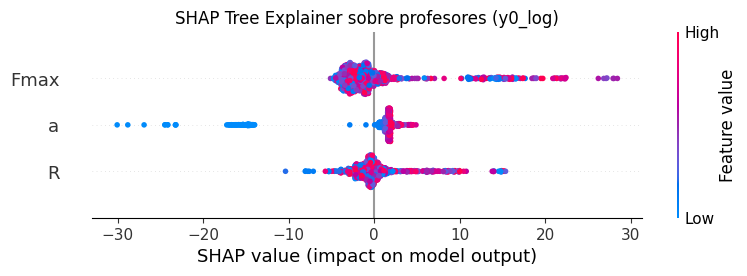

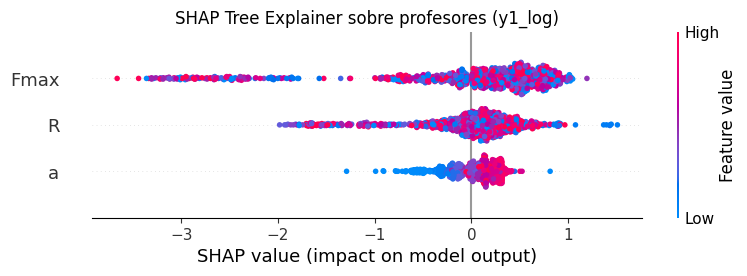

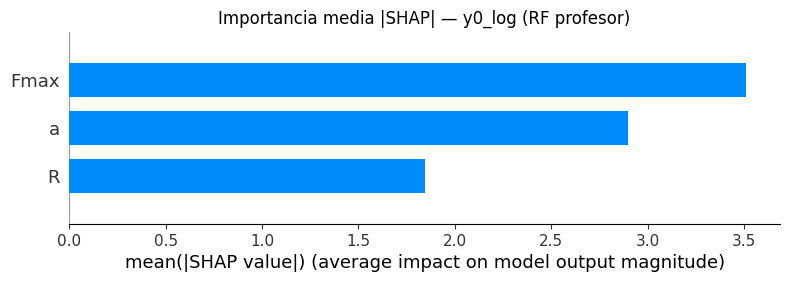

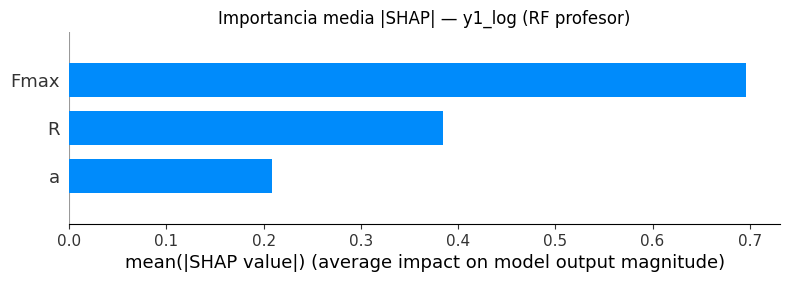

In [11]:
# Beeswarm y bar plots

shap.summary_plot(shap_values_y0, X_test, feature_names=FEATURE_COLS, show=False)
plt.title("SHAP Tree Explainer sobre profesores (y0_log)")
plt.show()

shap.summary_plot(shap_values_y1, X_test, feature_names=FEATURE_COLS, show=False)
plt.title("SHAP Tree Explainer sobre profesores (y1_log)")
plt.show()

shap.summary_plot(shap_values_y0, X_test, feature_names=FEATURE_COLS, plot_type="bar", show=False)
plt.title("Importancia media |SHAP| — y0_log (RF profesor)"); plt.show()

shap.summary_plot(shap_values_y1, X_test, feature_names=FEATURE_COLS, plot_type="bar", show=False)
plt.title("Importancia media |SHAP| — y1_log (RF profesor)"); plt.show()

In [12]:
#------------------------------------------------------------
# SHAP sobre el PIPELINE completo
#    - Usamos KernelExplainer con una función predictora por salida:
#      y0_log, y1_log (log-space); y2_orig, y3_orig (original)
#    - Mide sensibilidad respecto a X base (x1,x2,x3).
# ------------------------------------------------------------
print("\n[B] SHAP KernelExplainer sobre el pipeline completo (caja negra)")

# 1) Funciones de predicción por salida, dado X_base:
#    - Añaden features del stacking (RF), escalan, predicen, y devuelven
#      la salida en la ESCALA deseada para explicar.

def _augment_and_scale(X_base):
    """Crea X_aug=[X_base, y0_rf_log, y1_rf_log] y escala con scaler_X."""
    y0_rf_log = rf_y0.predict(X_base).reshape(-1,1)
    y1_rf_log = rf_y1.predict(X_base).reshape(-1,1)
    X_aug = np.hstack([X_base.astype("float32"), y0_rf_log, y1_rf_log]).astype("float32")
    X_aug_sc = scaler_X.transform(X_aug).astype("float32")
    return X_aug_sc


def _predict_heads_sc(X_base):
    """Predice heads (estandarizadas) a partir de X_base."""
    X_aug_sc = _augment_and_scale(X_base)
    y0_sc, y1_sc, y23_sc = model.predict(X_aug_sc, verbose=0)
    return y0_sc, y1_sc, y23_sc

def predict_y0_log(X_base):
    """Devuelve y0 en log-space (desestandarizado, SIN expm1)."""
    y0_sc, _, _ = _predict_heads_sc(X_base)
    Y_sc = np.zeros((len(y0_sc), 4), dtype="float32"); Y_sc[:,0] = y0_sc[:,0]
    Y_log = scaler_Y.inverse_transform(Y_sc)[:,0]  # desestandariza solo col-0
    return Y_log  # log-space

def predict_y1_log(X_base):
    """Devuelve y1 en log-space (desestandarizado, SIN expm1)."""
    _, y1_sc, _ = _predict_heads_sc(X_base)
    Y_sc = np.zeros((len(y1_sc), 4), dtype="float32"); Y_sc[:,1] = y1_sc[:,0]
    Y_log = scaler_Y.inverse_transform(Y_sc)[:,1]
    return Y_log  # log-space

def predict_y2_orig(X_base):
    """Devuelve y2 en ORIGINAL (desestandarizado)."""
    _, _, y23_sc = _predict_heads_sc(X_base)
    Y_sc = np.zeros((len(y23_sc), 4), dtype="float32"); Y_sc[:,2:4] = y23_sc
    Y_estd = scaler_Y.inverse_transform(Y_sc)
    return Y_estd[:,2]  # original

def predict_y3_orig(X_base):
    """Devuelve y3 en ORIGINAL (desestandarizado)."""
    _, _, y23_sc = _predict_heads_sc(X_base)
    Y_sc = np.zeros((len(y23_sc), 4), dtype="float32"); Y_sc[:,2:4] = y23_sc
    Y_estd = scaler_Y.inverse_transform(Y_sc)
    return Y_estd[:,3]  # original


[B] SHAP KernelExplainer sobre el pipeline completo (caja negra)


In [13]:
# Masker (Antecedentes y Explainers)

masker = shap.maskers.Independent(X_bg)  # asume independencia (rápido)
# Alternativa: usar directamente X_bg como background sin masker:
# expl = shap.KernelExplainer(predict_fn, X_bg)

expl_y0_full = shap.Explainer(predict_y0_log, masker)  # KernelExplainer por debajo
expl_y1_full = shap.Explainer(predict_y1_log, masker)
expl_y2_full = shap.Explainer(predict_y2_orig, masker)
expl_y3_full = shap.Explainer(predict_y3_orig, masker)


In [15]:
# SHAP values sobre X_test

sv_y0 = expl_y0_full(X_test)
sv_y1 = expl_y1_full(X_test)
sv_y2 = expl_y2_full(X_test)
sv_y3 = expl_y3_full(X_test)


ExactExplainer explainer: 1001it [22:07,  1.33s/it]
ExactExplainer explainer: 1001it [22:17,  1.35s/it]
ExactExplainer explainer: 1001it [21:55,  1.33s/it]
ExactExplainer explainer: 1001it [22:11,  1.34s/it]


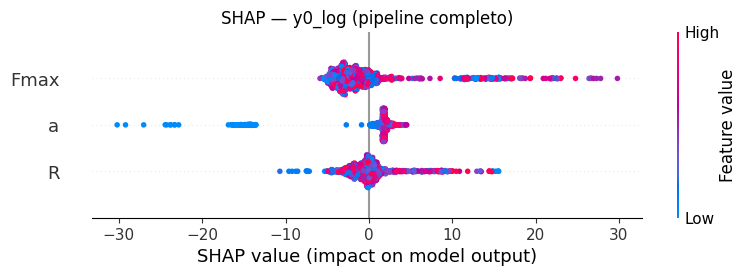

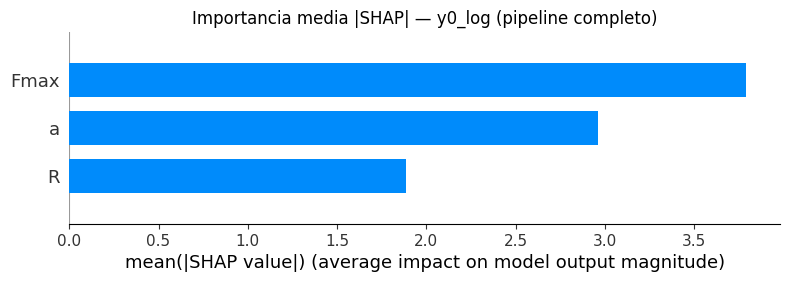

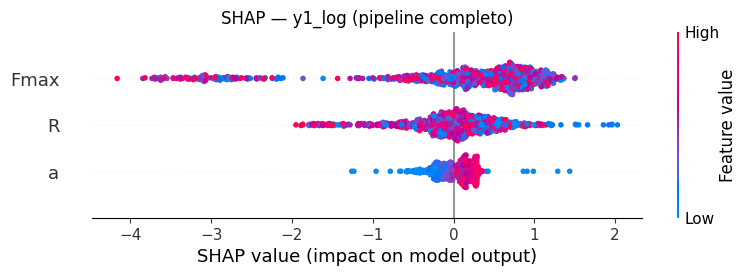

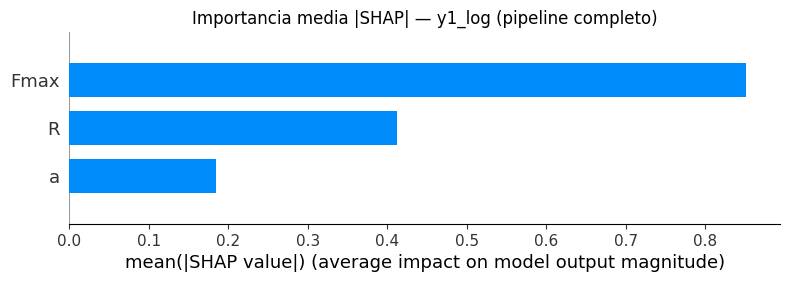

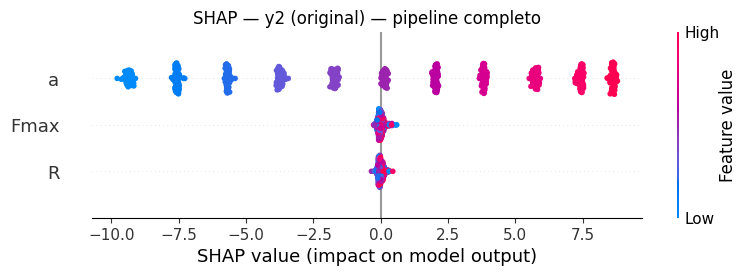

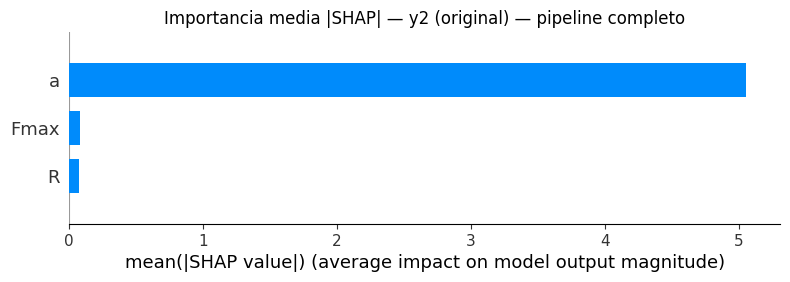

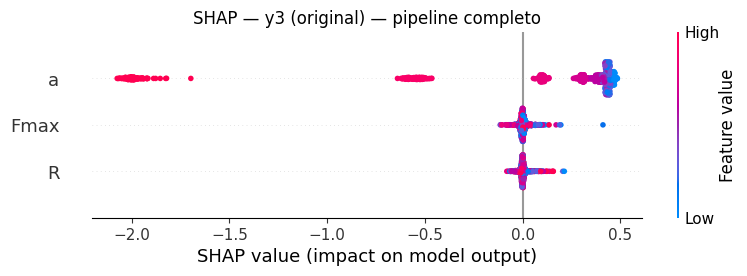

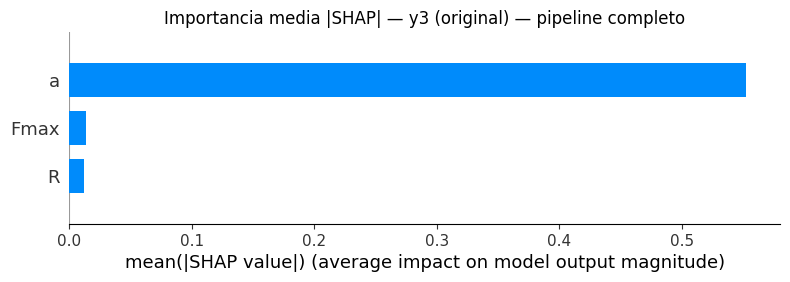

In [16]:
# 4) Plots (beeswarm y barras) por salida
def plot_full(sv, name):
    shap.summary_plot(sv.values, sv.data, feature_names=FEATURE_COLS, show=False)
    plt.title(f"SHAP — {name}"); plt.show()
    shap.summary_plot(np.abs(sv.values), sv.data, feature_names=FEATURE_COLS,
                      plot_type="bar", show=False)
    plt.title(f"Importancia media |SHAP| — {name}"); plt.show()

plot_full(sv_y0, "y0_log (pipeline completo)")
plot_full(sv_y1, "y1_log (pipeline completo)")
plot_full(sv_y2, "y2 (original) — pipeline completo")
plot_full(sv_y3, "y3 (original) — pipeline completo")

# 5) (Opcional) Dependence plots para relaciones 1D
# shap.dependence_plot("x1", sv_y1.values, sv_y1.data, feature_names=FEATURE_COLS)
# shap.dependence_plot("x2", sv_y1.values, sv_y1.data, feature_names=FEATURE_COLS)
# shap.dependence_plot("x3", sv_y1.values, sv_y1.data, feature_names=FEATURE_COLS)

